# Predicting having a Brain Stroke using Machine Learning

Working with this project I look at the following topics.
* [**Exploratory data analysis (EDA)**](#eda)
* [**Feature engineering**](#feature_engineering)
* [**Model training**](#modeling)
* [**Model evaluation and comparison**](#evaluation)
* [**Model fine-tuning**](#tuning) - once we've found a good model, how can we improve it?
* [**Cross-validation**](#validation)
* [**Feature importance**](#importance)


In this case, the problem is **binary classification**. I'm going to be using a number of differentrnet **features** about a person to predict whether they had a brain stroke or not.

In a statement,

> Given clinical parameters about a patient, can we predict whether or not they had a brain stroke?

The data is taken from **Kaggle**: <a href="https://www.kaggle.com/datasets/jillanisofttech/brain-stroke-dataset?datasetId=2387714&sortBy=voteCount"> Link <a>

## Features
Attribute Information

1) gender: "Male", "Female" or "Other"
2) age: age of the patient
3) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
4) heart disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease 5) Ever-married: "No" or "Yes"
6) work type: "children", "Govtjov", "Never worked", "Private" or "Self-employed" 7) Residencetype: "Rural" or "Urban"
8) avg glucose level: average glucose level in blood
9) BMI: body mass index
10) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
11) stroke: 1 if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

> If I can reach 95% accuracy at predicting whether or not a patient had a brain stroke during the proof of concept, I will pursure this project.

## Preparing the tools

The libraries I will use in this project:

* [pandas](https://pandas.pydata.org/) for data analysis.
* [NumPy](https://numpy.org/) for numerical operations.
* [Matplotlib](https://matplotlib.org/)/[seaborn](https://seaborn.pydata.org/) for plotting or data visualization.
* [Scikit-Learn](https://scikit-learn.org/stable/) for machine learning modelling and evaluation.

In [ ]:
# Regular EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Data Augmentation
from imblearn.over_sampling import SMOTE

# For plots to appear in the notebook
%matplotlib inline

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import auc

<a id="eda"><a>

## Exploratory data analysis (EDA)

In [ ]:
df = pd.read_csv("./brain_stroke.csv")

In [ ]:
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1


In [ ]:
df.stroke.value_counts(normalize=True)*100

0    95.02108
1     4.97892
Name: stroke, dtype: float64

The target (stroke) data is **imbalanced**, this may make harder the further evaluation of the model. This is also shown on the plot below.

For further plots I will create a list with preferable colors:

In [ ]:
colors = ['#e0abe0','#ace7e8', '#e32b56']

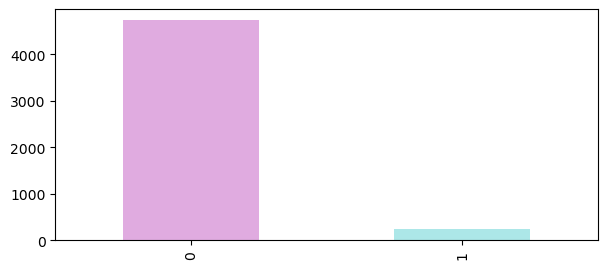

In [ ]:
df.stroke.value_counts().plot(kind="bar", figsize=(7,3), color=colors[:2]);

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [ ]:
df.describe() # getting insights with different metrics

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


#### Exploring crosstabs for the beginning analysis

In [ ]:
pd.crosstab(df.stroke, df.gender)

gender,Female,Male
stroke,,
0,2767,1966
1,140,108


There seems no big differences beetwen males and females concerning the rata of having a brain stroke

In [ ]:
pd.crosstab(df.stroke, df.heart_disease)

heart_disease,0,1
stroke,,
0,4505,228
1,201,47


In [ ]:
pd.crosstab(df.stroke, df.ever_married)

ever_married,No,Yes
stroke,,
0,1672,3061
1,29,219


As for having a heart disease or being married, it seems that there might be a connection - so i will try to investigate this possibility with visualisition

Text(0.5, 0, '0 = No Stroke, 1 = Stroke')

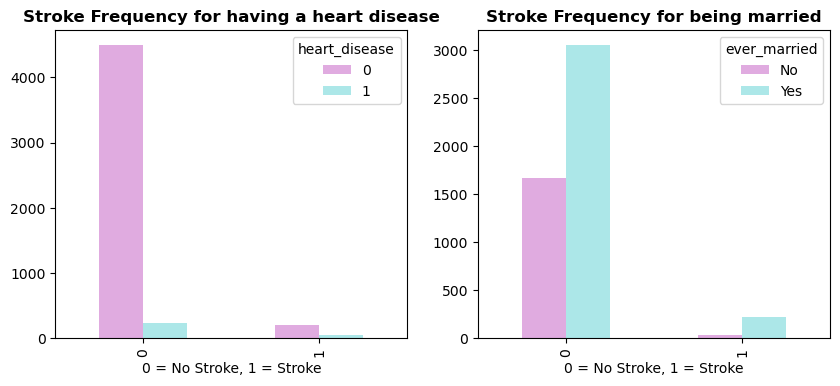

In [ ]:
# Create a plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
pd.crosstab(df.stroke, df.heart_disease).plot(kind='bar',
                                            color=colors[:2],
                                            ax=ax[0])
ax[0].set_title('Stroke Frequency for having a heart disease', fontweight='bold')
ax[0].set_xlabel('0 = No Stroke, 1 = Stroke')
pd.crosstab(df.stroke, df.ever_married).plot(kind='bar',
                                            color=colors[:2],
                                            ax=ax[1])
ax[1].set_title('Stroke Frequency for being married', fontweight='bold')
ax[1].set_xlabel('0 = No Stroke, 1 = Stroke')

Due to data being unbalanced, it is hard to make suggestions according to visualised plots. However, it is possible to notice that **the great part of people that had a stroke was married**

### **Exploring other parameters**.
This time I will try to see the connection with having a brain stroke for age  and BMI (body mass index).

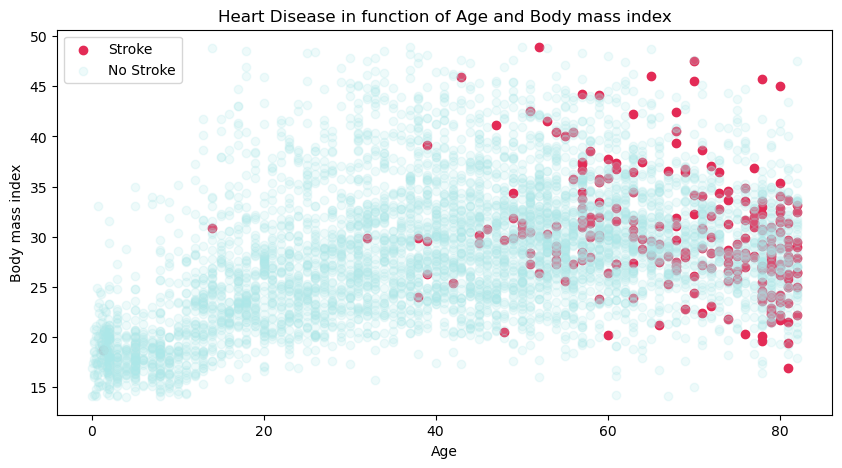

In [ ]:
# Create another figure
plt.figure(figsize=(10,5))

# Start with positve examples
plt.scatter(df.age[df.stroke==1],
            df.bmi[df.stroke==1],
            c=colors[2]) # define it as a scatter figure

# Now for negative examples, we want them on the same plot, so we call plt again
plt.scatter(df.age[df.stroke==0],
            df.bmi[df.stroke==0],
            c=colors[1], alpha=0.2) # axis always come as (x, y)

# Add some helpful info
plt.title("Heart Disease in function of Age and Body mass index")
plt.xlabel("Age")
plt.legend(["Stroke", "No Stroke"])
plt.ylabel("Body mass index");

Bevause of data being unbalanced I had to make cases with no stroke slightly transparent so it would be possible to see the cases of people that had a stroke. It looks like BMI is not that influential as age is. The older person is, the higher risk of having a stroke.

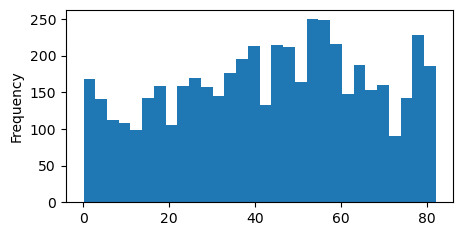

In [ ]:
df.age.plot.hist(bins=30, figsize = (5,2.5));

Since there might be a connection between brain stroke and age, bmi, I want to check whether the  distribution of these features is normal

In [ ]:
from scipy import stats

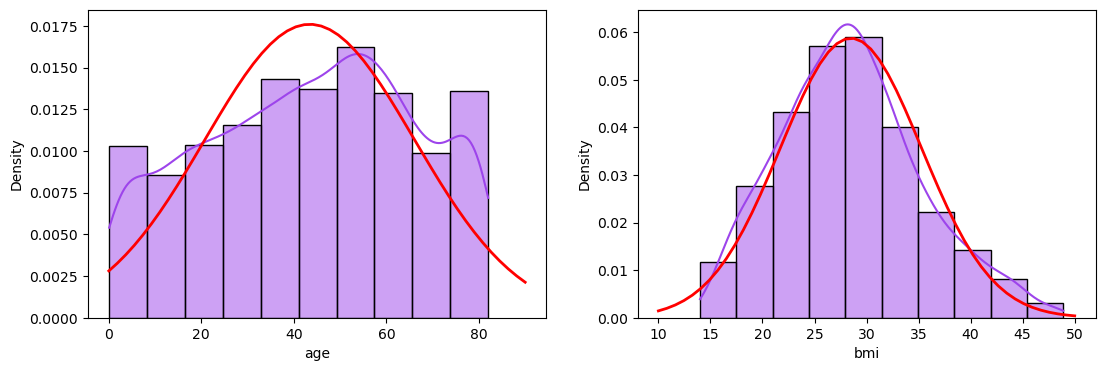

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
sns.histplot(df.age, bins=10, stat='density', kde=True, ax=ax[0], color = '#9d44eb')
xs = np.linspace(0,90)
pdf = stats.norm(df.age.mean(), df.age.std(ddof=1)).pdf(xs)
ax[0].plot(xs, pdf, lw=2, color='red')

sns.histplot(df.bmi, bins=10, stat='density', kde=True, ax=ax[1], color = '#9d44eb')
xs = np.linspace(10,50)
pdf = stats.norm(df.bmi.mean(), df.bmi.std(ddof=1)).pdf(xs)
ax[1].plot(xs, pdf, lw=2, color='red')
plt.show()


It is clear that age does not have normal distribution, however bmi might have, so I will check it with Kolmogorov-Smirnov test for goodness of fit

In [ ]:
stats.kstest(df.bmi, 'norm', args=(df.bmi.mean(), df.bmi.std(ddof=1)))

KstestResult(statistic=0.03419875045182452, pvalue=1.6983434414736683e-05, statistic_location=30.3, statistic_sign=1)

P-value is very low, which indicates that the hypothesis of normality of the distribution is rejected.

 **Smoking** is believed to be harmful for health. I want to explore if there might be connection between having a **brain stroke and smoking**

In [ ]:
pd.crosstab(df.smoking_status, df.stroke)

stroke,0,1
smoking_status,,
Unknown,1453,47
formerly smoked,797,70
never smoked,1749,89
smokes,734,42


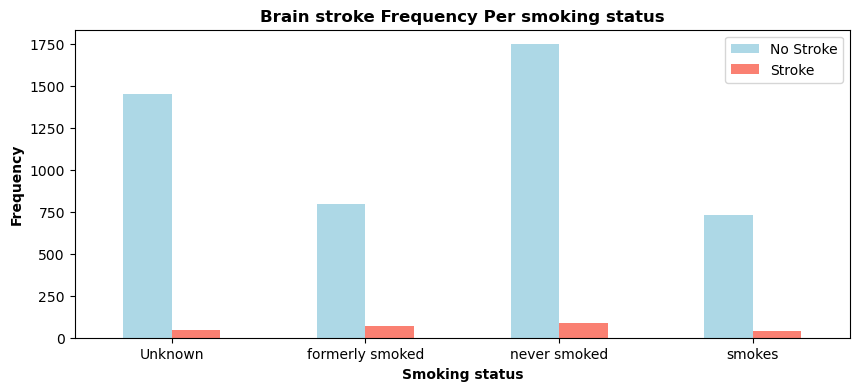

In [ ]:
pd.crosstab(df.smoking_status, df.stroke).plot(kind="bar",
                                   figsize=(10,4),
                                   color=["lightblue", "salmon"])

# Add attributes to the plot to make it more readable
plt.title("Brain stroke Frequency Per smoking status", fontweight='bold')
plt.xlabel("Smoking status", fontweight='bold')
plt.ylabel("Frequency", fontweight='bold')
plt.legend(["No Stroke", "Stroke"])
plt.xticks(rotation = 0);

It seems like there is no visible differences in frequency of brain strokes for people with different smoking status.

### Correlation between independent variables


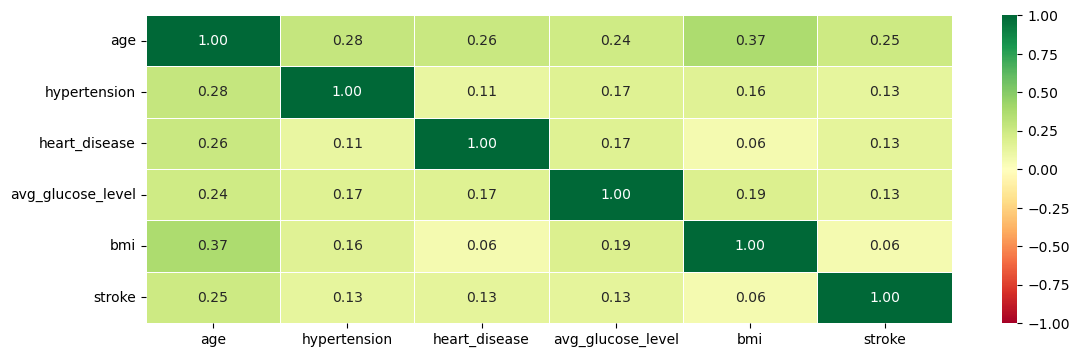

In [ ]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(13, 4))
sns.heatmap(corr_matrix,
            annot=True,
            vmin=-1,
            vmax=1,
            center=0,
            linewidths=0.5,
            fmt= ".2f",
            cmap="RdYlGn");

In [ ]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.278120,0.264852,0.236763,0.373703,0.246478
hypertension,0.278120,1.000000,0.111974,0.170028,0.158762,0.131965
heart_disease,0.264852,0.111974,1.000000,0.166847,0.060926,0.134610
avg_glucose_level,0.236763,0.170028,0.166847,1.000000,0.186348,0.133227
bmi,0.373703,0.158762,0.060926,0.186348,1.000000,0.056926
stroke,0.246478,0.131965,0.134610,0.133227,0.056926,1.000000


It seems like there is no strong correlations between independent variables

<a id="feature_engineering"><a>

## Feature engineering

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


First, I will try to handle non-numeric parameters in order to use them in boulding a model. Lets look what values they consist of:

In [ ]:
non_numeric_list = [df.gender, df.ever_married, df.work_type, df.Residence_type, df.smoking_status]

for i in non_numeric_list:
    print (f'The number of values for <{i.name}> is {len(i.unique())}: {", ".join(i.unique())}')

The number of values for <gender> is 2: Male, Female
The number of values for <ever_married> is 2: Yes, No
The number of values for <work_type> is 4: Private, Self-employed, Govt_job, children
The number of values for <Residence_type> is 2: Urban, Rural
The number of values for <smoking_status> is 4: formerly smoked, never smoked, smokes, Unknown


As for these parameters to use them in further model boulding I will use one-hot encoding to convert them.

In [ ]:
encoded_df = pd.get_dummies(df, columns = ['gender', 'ever_married', 'work_type',
                                                     'Residence_type', 'smoking_status' ])
encoded_df.head(3)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1


Now I am able to use this dataset for building models

<a id="modeling"><a>

## Modeling

First, I split the target variable from the rest.

In [ ]:
X = encoded_df.drop("stroke", axis=1)
y = encoded_df.stroke.values # Target variable

The data is severly imbalanced, so in order to avoid  poor perfomance (minority class in this dataset is most important, but in current state of the data it most probably will be ignored) I will use **Data Augmentation** for the minority class. I will use **SMOTE** (Synthetic Minority Oversampling Technique)

In [ ]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [ ]:
np.unique(y, return_counts=True)

(array([0, 1]), array([4733, 4733]))

Now data is balanced so I am not afraid of model's ingoring positive target value

Now I split the data into a **training set** and a **test set**.
To do this I  use Scikit-Learn's [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and feed it independent and dependent variables (`X` & `y`).

In [ ]:
np.random.seed(97) #setting random seed for reproducibility

# Splitting into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

I will use the following and comparing their results.

1. Logistic Regression - [`LogisticRegression()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
2. K-Nearest Neighbors - [`KNeighboursClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
3. RandomForest - [`RandomForestClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

All of the algorithms in the Scikit-Learn library use the same functions, for training a model, `model.fit(X_train, y_train)` and for scoring a model `model.score(X_test, y_test)`. `score()` returns the ratio of correct predictions.

Since the chosen algorithms implement the same methods for fitting them to the data as well as evaluating them, I will put them in a dictionary and create a function which fits and scores them.

In [ ]:
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(),
          "Random Forest": RandomForestClassifier()}

# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(97)
    model_scores = {}

    for name, model in models.items():
        if name == "KNN":
            model.fit(X_train, y_train)
            # transforming df to np array to make it c-contiguous
            model_scores[name] = model.score(X_test.to_numpy(), y_test)
        else:
            model.fit(X_train, y_train)
            model_scores[name] = model.score(X_test, y_test)
    return model_scores

<a id="evaluation"><a>

## Model evaluation and comparison

Now I will find the accuracy for each model using earlier defined function

In [ ]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

/Users/alexeyks/Coding/ml-course/brain-stroke-classifier/env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/alexeyks/Coding/ml-course/brain-stroke-classifier/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'KNN': 0.8875395987328405,
 'Logistic Regression': 0.9413938753959873,
 'Random Forest': 0.9693769799366421}

I will also visualize models' accuracy

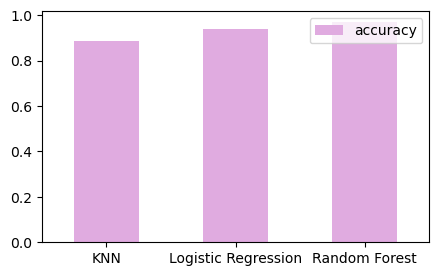

In [ ]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar(color = colors[0], figsize = (5,3));
plt.xticks(rotation = 0)
# fig.bar_label(fig.containers[0], label_type='edge')
plt.show()

<a id="tuning"><a>

## Hyperparameter tuning

**KNN** classsifier has the smallest accuracy but since the diffrence from the other models is not significant, first I will try to tune this model

For this I will use main hyperparameter that can be tuned for the K-Nearest Neighbors (KNN) algorithm - number of neighbours. The default is n_neigbors=5

I will create a loop which tries different values of n_neighbors and checks the accuracy for train and test sets

In [ ]:
train_scores = []
test_scores = []

neighbors = range(1, 21) # 1 to 20
knn = KNeighborsClassifier()

for i in neighbors:
    knn.set_params(n_neighbors = i)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train.to_numpy(), y_train))
    test_scores.append(knn.score(X_test.to_numpy(), y_test))

/Users/alexeyks/Coding/ml-course/brain-stroke-classifier/env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/alexeyks/Coding/ml-course/brain-stroke-classifier/env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/alexeyks/Coding/ml-course/brain-stroke-classifier/env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/alexeyks/Coding/ml-course/brain-stroke-classifier/env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/alexeyks/Coding/ml-course/brain-stroke-classifier/env/lib/pyt

/Users/alexeyks/Coding/ml-course/brain-stroke-classifier/env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/alexeyks/Coding/ml-course/brain-stroke-classifier/env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/alexeyks/Coding/ml-course/brain-stroke-classifier/env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


To demonstrate the results I will build a plot

Maximum KNN score on the test data: 91.92%. For this result model used the value of n_neighbors = 1.


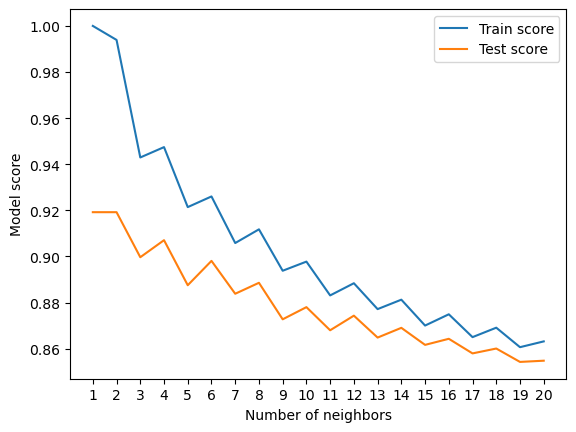

In [ ]:
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1, 21))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%. For this result model \
used the value of n_neighbors = {test_scores.index(max(test_scores))+1}.")

To tune parameters for Logistic regresiion and Random Forest Classifier I will use **RandomizedSearchCV**.

First, I will create hyperparameters grid for each model

In [ ]:
# Different LogisticRegression hyperparameters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(100, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

Now I will try to tune **LogisticRegression** model. Since the dataset is quite big, I will set number of iterations to 20 and number of cross validations to 5 (default). So the RandomizedSearchCV will fit 100 combinations

In [ ]:
np.random.seed(97)

rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

rs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 10000.0}

In [ ]:
rs_log_reg.score(X_test, y_test)

0.9604012671594508

Tuning increased accuracy of this model for a bit, but it is still less than Random Forest model has

Now I will do the same with **RandomForestClassifier**

In [ ]:
np.random.seed(97)

rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                                param_distributions=rf_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

rs_rf.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
rs_rf.best_params_

{'n_estimators': 850,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_depth': None}

In [ ]:
rs_rf.score(X_test, y_test)

0.9704329461457233

Tuning parameters using RandomisedSEarchCV gave some result, but I will also try **GridSearchCV** for logistic Regression and Random Forest Classifier models

**Logistic Regression model**

In [ ]:
np.random.seed(97)
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

gs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
gs_log_reg.best_params_

{'C': 10000.0, 'solver': 'liblinear'}

In [ ]:
gs_log_reg.score(X_test, y_test)

0.9604012671594508

Still less than Random Forest Model's accuracy, so I will use the RF model as the best one

## Now I will evaluate the model with other metrics

I will explore model's **ROC curve and UAC score, Confusion matrix, Classification report, Precision, Recall, F1-score**

In [ ]:
y_pred = rs_rf.predict(X_test)

In [ ]:
y_pred

array([1, 1, 0, ..., 1, 1, 0])

In [ ]:
# Plot ROC curve and calculate AUC metric
RocCurveDisplay(rs_rf, X_test, y_test);

TypeError: RocCurveDisplay.__init__() takes 1 positional argument but 4 were given

### ROC Curve and AUC Scores

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Random Forest RandomizedSearchCV')
display.plot()
plt.show()

### Confusion matrix

In [ ]:
confusion_matrix(y_test, y_pred)

I will create a function that uses heatmap() to show visual confucion matrix

In [ ]:
def plot_conf_mat(y_test, y_pred):

    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                     annot=True,
                     cbar=False,
                     cmap="RdYlGn")

    plt.xlabel("Predicted label")
    plt.ylabel("True label")

plot_conf_mat(y_test, y_pred)

<a id="validation"><a>

## Cross Validation, Classification report

A **classification report** will also give information of the precision and recall of our model for each class.

In [ ]:
report = classification_report(y_test, y_preds)
print(report)

Now I want to use cross validation to get more accurate values

In [ ]:
rs_rf.best_params_

In [ ]:
clf = RandomForestClassifier(n_estimators=850,
                            min_samples_split=12,
                            min_samples_leaf=1,
                            max_depth=None)

In [ ]:
cv_acc = cross_val_score(clf,
                         X,
                         y,
                         cv=5, # 5-fold cross-validation
                         scoring="accuracy") # accuracy as scoring
cv_acc

In [ ]:
cv_acc = np.mean(cv_acc)
cv_acc

I will also calculate other classification matrics using cross validation, but only with **cv=3** since the dataset is big

In [ ]:
cv_precision = np.mean(cross_val_score(clf, X, y, cv=3, scoring="precision"))
cv_precision

In [ ]:
cv_recall = np.mean(cross_val_score(clf, X, y, cv=3, scoring="recall"))
cv_recall

In [ ]:
cv_f1 = np.mean(cross_val_score(clf, X, y, cv=3, scoring="f1"))
cv_f1

Now I will visualize the results

In [ ]:
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                            "Precision": cv_precision,
                            "Recall": cv_recall,
                            "F1": cv_f1},
                          index=[0])
cv_metrics.T.plot.bar(title="Cross-Validated Metrics", legend=False, color=colors[0]);

<a id="importance"><a>

## Feature importance

I will also try to explote which features contributing most to the outcomes of the model

In [ ]:
clf.fit(X_train, y_train)

To compute feature importance I will use **The Mean Decrease Impurity** which is calculated using Gini index or the entropy. It computes the average impurity reduction over all the trees in the forest. The higher the impurity reduction, the more important the feature is

In [ ]:
importance = clf.feature_importances_
importance

In [ ]:
features_dict = dict(zip(encoded_df.columns, list(importance)))
features_dict

I will also visualize the feature coefficients

In [ ]:
features_df = pd.DataFrame(features_dict, index=[0])
features_df.T.plot.bar(title="Feature Importance", legend=False);

So, the question in the beginning was:

> If I can reach 95% accuracy at predicting whether or not a patient had a brain stroke during the proof of concept, I will pursue this project.

## Since the best accuracy I achieved is higher than 95%, I assess this model as successful and potentially useful